In [78]:
import functools
import pathlib
import pickle
import warnings

import numpy as np
import pandas as pd
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, 
                              ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

import model_util

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [56]:
data = pathlib.Path.cwd() / 'data'
npys = data / 'npys'
pkls = data / 'pkls'
models = data / 'models'

In [3]:
def merge_features(name):
    """Merge all serialized features into a single dataframe.
    
    Parameters
    ----------
    name : str
        'train' or 'valid'
    
    Returns
    -------
    df : DataFrame
        DataFrame with all the features combined.
    """
    
    essay_df = pd.read_pickle(pkls / f'{name}.pkl')
    descr_df = pd.read_pickle(pkls / 'descr.pkl')[['essay_set', 'grade_level']]
    essay_to_grade_level = descr_df.set_index('essay_set').to_dict()['grade_level']
    
    grade_level_arr = essay_df['essay_set'].map(essay_to_grade_level).values
    grade_level_df = pd.DataFrame(grade_level_arr, columns=['grade_level'])
    
    promt_count_arr = np.load(npys / f'{name}_prompt_count.npy')
    promt_count_df = pd.DataFrame(promt_count_arr, columns=['prompt_count'])
    
    promt_tfidf_arr = np.load(npys / f'{name}_prompt_tfidf.npy')
    promt_tfidf_df = pd.DataFrame(promt_tfidf_arr, columns=['prompt_tfidf'])

    pos_df = pd.read_pickle(pkls / f'{name}_pos.pkl')
    pos_df = pos_df.div(pos_df.sum(axis=1), axis=0)
    
    percent_df = essay_df[['domain1_percent', 'domain2_percent']]
    sentiment_df = pd.read_pickle(pkls / f'{name}_sentiment.pkl')
    diff_level_df = pd.read_pickle(pkls / f'{name}_grade_level.pkl')
    
    dfs = [grade_level_df, percent_df, promt_count_df, promt_tfidf_df,
           diff_level_df, sentiment_df, pos_df]
    return pd.concat(dfs, axis=1)

In [4]:
train_df = merge_features('train')
train_df.head()

,grade_level,domain1_percent,domain2_percent,prompt_count,prompt_tfidf,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,8,60.0,NaN,0.415474,0.297531,74.02,10.4,8.5,8.48,11.3,...,0.063218,0.002874,0.040230,0.011494,0.034483,0.040230,0.000000,0.002874,0.0,0.005747
1,8,70.0,NaN,0.339572,0.235998,67.08,11.6,9.1,7.78,9.9,...,0.067130,0.018519,0.046296,0.009259,0.037037,0.013889,0.004630,0.000000,0.0,0.020833
2,8,50.0,NaN,0.638644,0.529368,68.20,12.0,8.7,8.24,9.8,...,0.044828,0.003448,0.031034,0.000000,0.079310,0.024138,0.000000,0.017241,0.0,0.010345
3,8,80.0,NaN,0.418874,0.286866,53.34,13.9,12.3,11.20,15.4,...,0.052910,0.031746,0.008818,0.015873,0.042328,0.021164,0.003527,0.005291,0.0,0.007055
4,8,60.0,NaN,0.411188,0.297567,72.66,11.3,7.0,7.83,7.5,...,0.088795,0.004228,0.012685,0.004228,0.035941,0.038055,0.006342,0.002114,0.0,0.010571


In [5]:
valid_df = merge_features('valid')
valid_df.head()

,grade_level,domain1_percent,domain2_percent,prompt_count,prompt_tfidf,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,8,50.0,NaN,0.565212,0.410547,56.59,12.7,11.1,10.39,13.3,...,0.041841,0.008368,0.046025,0.008368,0.058577,0.020921,0.000000,0.008368,0.0,0.008368
1,8,60.0,NaN,0.370156,0.274027,80.31,10.2,6.1,5.86,6.4,...,0.081325,0.012048,0.012048,0.009036,0.066265,0.030120,0.000000,0.006024,0.0,0.015060
2,8,70.0,NaN,0.401037,0.297338,64.88,11.9,12.0,7.85,14.6,...,0.057778,0.013333,0.062222,0.006667,0.040000,0.033333,0.006667,0.006667,0.0,0.004444
3,8,70.0,NaN,0.325612,0.227408,73.17,9.9,6.8,7.30,7.1,...,0.090426,0.000000,0.031915,0.007979,0.071809,0.013298,0.000000,0.005319,0.0,0.023936
4,8,70.0,NaN,0.549260,0.404606,74.90,10.2,6.1,7.58,6.6,...,0.052980,0.000000,0.017660,0.000000,0.066225,0.015453,0.013245,0.004415,0.0,0.004415


In [6]:
X_train = train_df.drop(columns=['domain1_percent', 'domain2_percent'])
y_train = train_df['domain1_percent']

X_valid = valid_df.drop(columns=['domain1_percent', 'domain2_percent'])
y_valid = valid_df['domain1_percent']

In [99]:
X_train.head()

,grade_level,prompt_count,prompt_tfidf,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,linsear_write_formula,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,8,0.415474,0.297531,74.02,10.4,8.5,8.48,11.3,5.88,8.666667,...,0.063218,0.002874,0.040230,0.011494,0.034483,0.040230,0.000000,0.002874,0.0,0.005747
1,8,0.339572,0.235998,67.08,11.6,9.1,7.78,9.9,6.49,10.166667,...,0.067130,0.018519,0.046296,0.009259,0.037037,0.013889,0.004630,0.000000,0.0,0.020833
2,8,0.638644,0.529368,68.20,12.0,8.7,8.24,9.8,6.66,8.142857,...,0.044828,0.003448,0.031034,0.000000,0.079310,0.024138,0.000000,0.017241,0.0,0.010345
3,8,0.418874,0.286866,53.34,13.9,12.3,11.20,15.4,7.74,16.000000,...,0.052910,0.031746,0.008818,0.015873,0.042328,0.021164,0.003527,0.005291,0.0,0.007055
4,8,0.411188,0.297567,72.66,11.3,7.0,7.83,7.5,5.83,8.714286,...,0.088795,0.004228,0.012685,0.004228,0.035941,0.038055,0.006342,0.002114,0.0,0.010571


In [7]:
metrics = [mean_absolute_error, mean_squared_error, r2_score]
grid_cv = functools.partial(model_util.grid_search_cv, X=X_train, y=y_train)
score_est = functools.partial(model_util.score_estimator, 
                              metrics=metrics, 
                              X=X_train,
                              y=y_train)
plot_resid = functools.partial(model_util.plot_residuals, X=X_train, y=y_train)

In [86]:
def score(fit_estimator, X, y):
    pred = fit_estimator.predict(X)
    return {m.__name__: m(y, pred) for m in metrics}


def save_model(model, name):
    file = models / f'{name}.pkl'
    with open(file, 'wb') as fp:
        pickle.dump(model, fp)

# Linear Regression

In [67]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
score(linear_reg, X_train, y_train)

{'mean_absolute_error': 14.90905011104642,
 'mean_squared_error': 369.6455603936238,
 'r2_score': 0.32626536106928083}

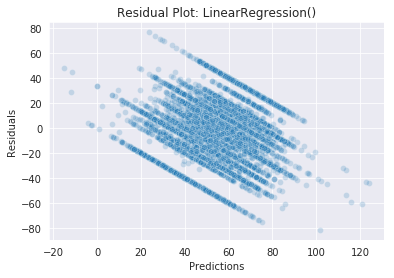

In [68]:
plot_resid(linear_reg)

In [87]:
save_model(linear_reg, 'linear_reg')

# Lasso

In [16]:
param_grid = {'alpha': [10**i for i in range(-3, 4)], 'max_iter': [10_000]}
lasso_best = grid_cv(Lasso(), param_grid)
lasso_best

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.01, 'max_iter': 10000}

In [69]:
lasso = Lasso(**lasso_best)
lasso.fit(X_train, y_train)
score(lasso, X_train, y_train)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'mean_absolute_error': 15.160187907044532,
 'mean_squared_error': 380.40371781469764,
 'r2_score': 0.30665700083920344}

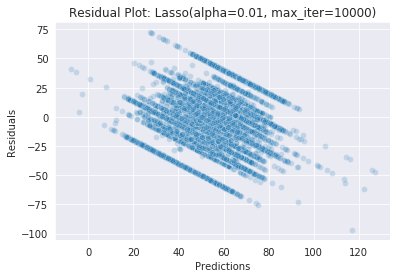

In [42]:
plot_resid(lasso)

In [88]:
save_model(lasso, 'lasso')

# Ridge

In [20]:
param_grid = {'alpha': [10**i for i in range(-3, 4)]}
ridge_best = grid_cv(Ridge(), param_grid)
ridge_best

{'alpha': 10}

In [70]:
ridge = Ridge(**ridge_best)
ridge.fit(X_train, y_train)
score(ridge, X_train, y_train)

{'mean_absolute_error': 15.274976928820909,
 'mean_squared_error': 385.5635203645344,
 'r2_score': 0.2972524845123572}

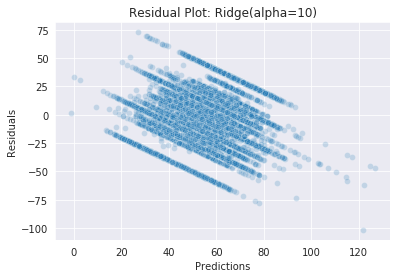

In [41]:
plot_resid(ridge)

In [89]:
save_model(ridge, 'ridge')

# SVM Regressor

In [23]:
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
svr_best = grid_cv(SVR(), param_grid)
svr_best

{'kernel': 'rbf'}

In [71]:
svr = SVR(**svr_best)
svr.fit(X_train, y_train)
score(svr, X_train, y_train)

{'mean_absolute_error': 14.735326940552477,
 'mean_squared_error': 384.5142465932981,
 'r2_score': 0.2991649438007917}

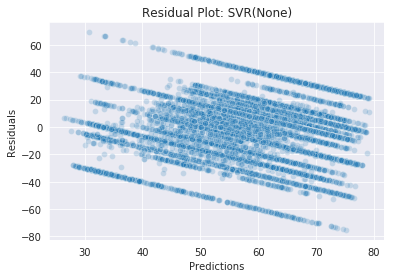

In [26]:
plot_resid(svr)

In [90]:
save_model(svr, 'svr')

# Random Forest

In [52]:
param_grid = {'criterion': ['mse', 'mae'], 'n_jobs': [-1], 'random_state': [0]}
randforest_best = grid_cv(RandomForestRegressor(), param_grid)
randforest_best

{'criterion': 'mse', 'n_jobs': -1, 'random_state': 0}

In [72]:
rand_forest = RandomForestRegressor(**randforest_best)
rand_forest.fit(X_train, y_train)
score(rand_forest, X_train, y_train)

{'mean_absolute_error': 5.360344739005344,
 'mean_squared_error': 55.95773607685984,
 'r2_score': 0.8980086083788551}

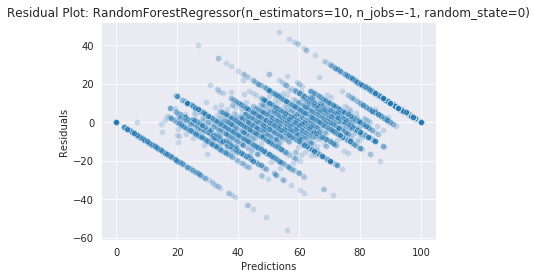

In [54]:
plot_resid(rand_forest)

In [91]:
save_model(rand_forest, 'rand_forest')

# Extra Trees

In [35]:
param_grid = {'criterion': ['mse', 'mae'], 'n_jobs': [-1], 'random_state': [0]}
extra_trees_best = grid_cv(ExtraTreesRegressor(), param_grid)
extra_trees_best

{'criterion': 'mse', 'n_jobs': -1, 'random_state': 0}

In [73]:
extra_trees = ExtraTreesRegressor(**extra_trees_best)
extra_trees.fit(X_train, y_train)
score(extra_trees, X_train, y_train)

{'mean_absolute_error': 0.00770653514180309,
 'mean_squared_error': 0.21407042060556242,
 'r2_score': 0.99960982445622}

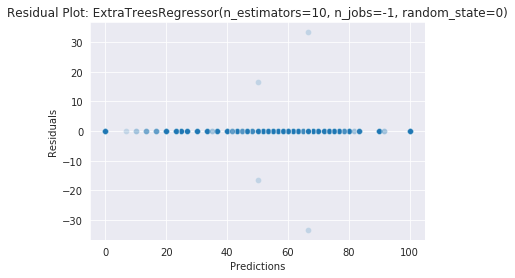

In [51]:
plot_resid(extra_trees)

In [92]:
save_model(extra_trees, 'extra_trees')

# AdaBoost

### Linear Regression

In [74]:
ada_boost_linear = AdaBoostRegressor(LinearRegression(), random_state=0)
ada_boost_linear.fit(X_train, y_train)
score(ada_boost_linear, X_train, y_train)

{'mean_absolute_error': 15.070540031463684,
 'mean_squared_error': 372.0827073343724,
 'r2_score': 0.32182329415415856}

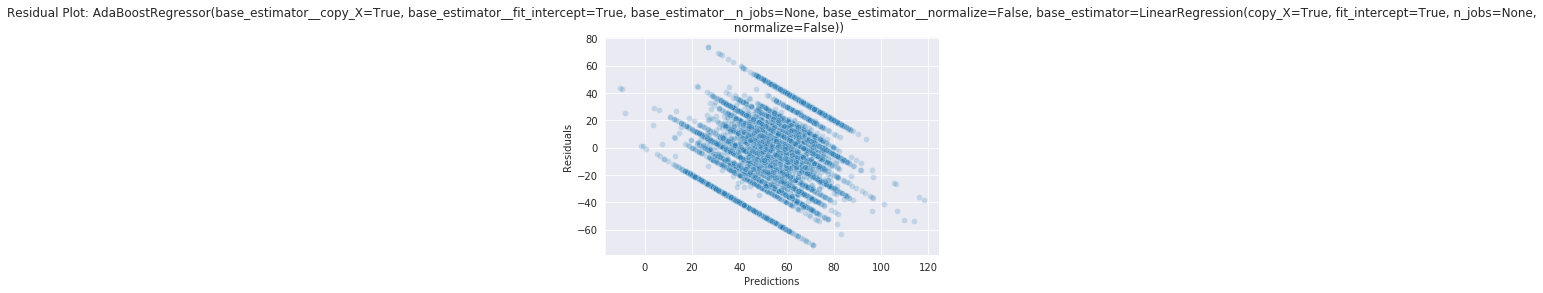

In [61]:
plot_resid(ada_boost_linear)

In [93]:
save_model(ada_boost_linear, 'ada_boost_linear')

# Bagging

### Linear Regression

In [75]:
bagging_linear = BaggingRegressor(LinearRegression(), n_jobs=-1, random_state=0)
bagging_linear.fit(X_train, y_train)
score(bagging_linear, X_train, y_train)

{'mean_absolute_error': 14.899438151505802,
 'mean_squared_error': 369.83677797804876,
 'r2_score': 0.3259168382571509}

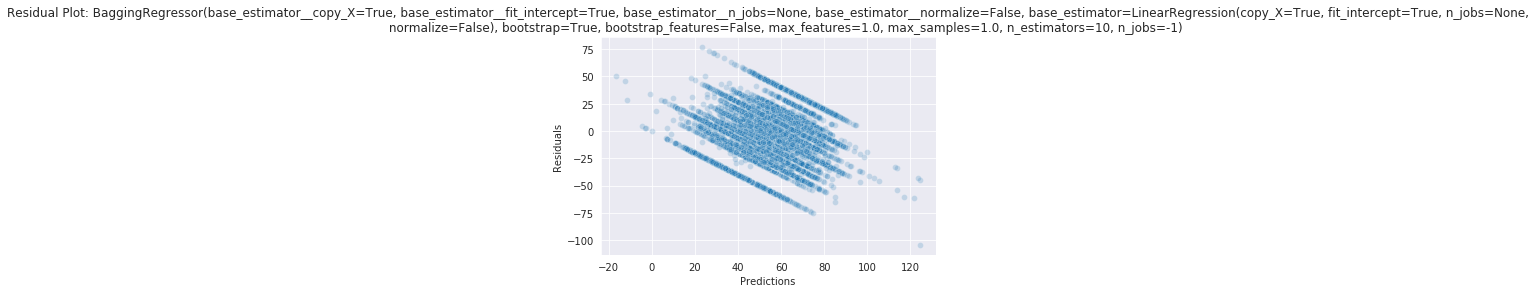

In [64]:
plot_resid(bagging_linear)

In [94]:
save_model(bagging_linear, 'bagging_linear')

### Lasso

### Ridge

### SVR

In [76]:
bagging_svr = BaggingRegressor(SVR(), n_jobs=-1, random_state=0)
bagging_svr.fit(X_train, y_train)
score(bagging_svr, X_train, y_train)

{'mean_absolute_error': 14.748127401508476,
 'mean_squared_error': 384.3406251972086,
 'r2_score': 0.2994813949127174}

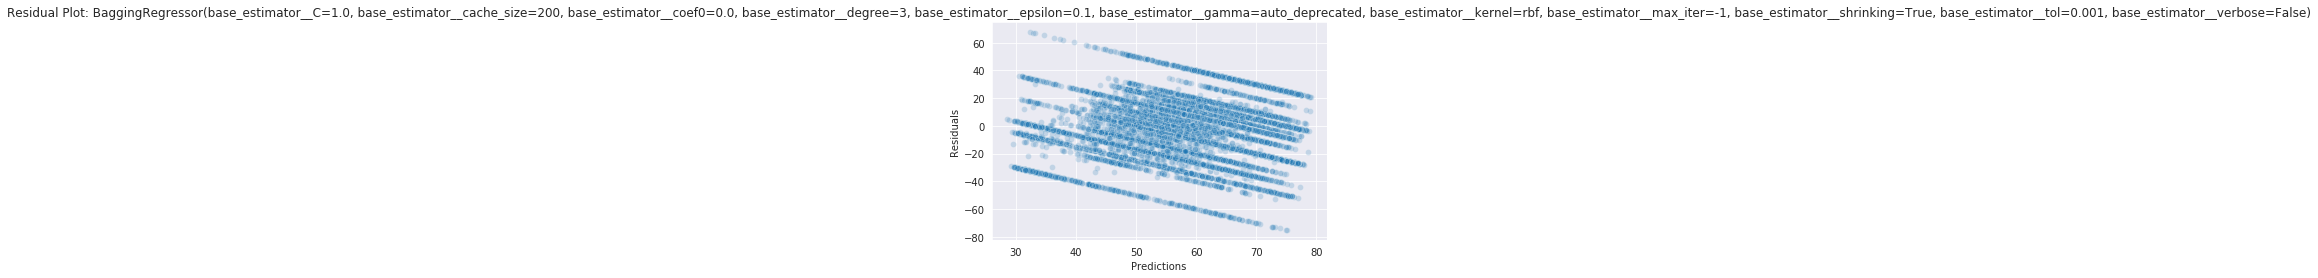

In [77]:
plot_resid(bagging_svr)

In [95]:
save_model(bagging_svr, 'bagging_svr')

# Gradient Boosting

In [97]:
param_grid = {'loss': ['ls', 'lad', 'huber'], 'random_state': [0]}
gradient_boost_best = grid_cv(GradientBoostingRegressor(), param_grid)
gradient_boost_best

{'loss': 'huber', 'random_state': 0}

In [98]:
gradient_boost = GradientBoostingRegressor(**gradient_boost_best)
gradient_boost.fit(X_train, y_train)
score(gradient_boost, X_train, y_train)

{'mean_absolute_error': 12.042495190869928,
 'mean_squared_error': 248.57934014684102,
 'r2_score': 0.5469267592416693}

In [105]:
score(gradient_boost, X_valid, y_valid)

{'mean_absolute_error': 11.485501396856137,
 'mean_squared_error': 227.16956316873797,
 'r2_score': 0.5119391503816251}

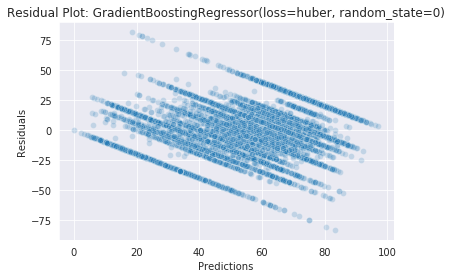

In [99]:
plot_resid(gradient_boost)

In [100]:
save_model(gradient_boost, 'gradient_boost')

In [38]:
from importlib import reload
reload(model_util);

# JobLib Serialize Models

In [106]:
pathlib.Path.cwd()

PosixPath('/home/ubuntu/EssayScorer/EssayScorer')